In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC, SVR
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, mean_squared_error, silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
np.random.seed(42)

In [ ]:
# ======================== DATA PREPARATION ========================
def load_svm_classification_data(csv_path, val_size=0.2):
    """Load data for SVM classification"""
    data = pd.read_csv(csv_path)
    X = data[['Pregnancies', 'Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].values
    y = (data['Outcome'] > 0).astype(int).values
    # Train-val split
    split_idx = int(len(X) * (1 - val_size))
    indices = np.random.permutation(len(X))
    X_train = X[indices[:split_idx]]
    y_train = y[indices[:split_idx]]
    X_val = X[indices[split_idx:]]
    y_val = y[indices[split_idx:]]
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler

def load_svm_regression_data(csv_path, val_size=0.2):
    """Load data for SVM regression"""
    data = pd.read_csv(csv_path)
    X = data[['dim1', 'dim2', 'value']].values
    y = data['winning_bid'].values
    # Train-val split
    split_idx = int(len(X) * (1 - val_size))
    indices = np.random.permutation(len(X))
    X_train = X[indices[:split_idx]]
    y_train = y[indices[:split_idx]]
    X_val = X[indices[split_idx:]]
    y_val = y[indices[split_idx:]]
    # Standardize features and target
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_val = X_scaler.transform(X_val)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_val = y_scaler.transform(y_val.reshape(-1, 1)).ravel()
    return X_train, y_train, X_val, y_val, X_scaler, y_scaler

def load_kmeans_data(csv_path, val_size=0.2):
    """Load data for K-Means clustering"""
    data = pd.read_csv(csv_path)
    # Using same features as SVM classification for comparison
    X = data[['Pregnancies', 'Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].values
    # Train-val split (though unsupervised, we might want to evaluate on held-out data)
    split_idx = int(len(X) * (1 - val_size))
    indices = np.random.permutation(len(X))
    X_train = X[indices[:split_idx]]
    X_val = X[indices[split_idx:]]
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    return X_train, X_val, scaler

In [ ]:
def visualize_classification_data(X, y, feature_names):
    """Visualize features vs binary classes"""
    plt.figure(figsize=(15, 5))
    for i in range(X.shape[1]):
        plt.subplot(2, 4, i+1)
        plt.scatter(X[:, i], y, c=y, cmap='coolwarm', alpha=0.7)
        plt.xlabel(feature_names[i])
        plt.ylabel('Class (0/1)')
    plt.tight_layout()
    plt.show()

def visualize_regression_data(X, y, feature_names):
    """Visualize features vs continuous target"""
    plt.figure(figsize=(15, 5))
    for i in range(X.shape[1]):
        plt.subplot(1, X.shape[1], i+1)
        plt.scatter(X[:, i], y, alpha=0.5)
        plt.xlabel(feature_names[i])
        plt.ylabel('Winning Bid')
    plt.tight_layout()
    plt.show()

def visualize_clusters(X, labels, feature_names, title="Cluster Visualization"):
    """Visualize clusters using first two features"""
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.colorbar()
    plt.show()

In [ ]:
# ======================== SVM IMPLEMENTATION ========================
class SVMFromScratch:
    """Simplified SVM implementation from scratch (for educational purposes)"""
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.training_history = {'loss': [], 'epoch': []}

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Convert y to -1 and 1
        y_ = np.where(y <= 0, -1, 1)
        # Initialize weights
        self.w = np.zeros(n_features)
        self.b = 0
        # Gradient descent
        for epoch in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]
            # Calculate loss for tracking
            loss = self.lambda_param * np.sum(self.w**2) + np.mean(
                np.maximum(0, 1 - y_ * (np.dot(X, self.w) - self.b)))
            self.training_history['loss'].append(loss)
            self.training_history['epoch'].append(epoch)

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

In [ ]:
# ======================== K-MEANS IMPLEMENTATION ========================
class KMeansFromScratch:
    """K-Means clustering implementation from scratch"""
    def __init__(self, K=3, max_iters=100):
        self.K = K
        self.max_iters = max_iters
        self.centroids = None
        self.labels = None
        self.inertia = None
        self.training_history = {'inertia': [], 'iteration': []}

    def initialize_centroids(self, X):
        """Initialize centroids using random samples"""
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.K]]
        return centroids

    def compute_distance(self, X, centroids):
        """Compute distance between each point and each centroid"""
        distances = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        return distances

    def find_closest_centroid(self, distances):
        """Assign each point to the closest centroid"""
        return np.argmin(distances, axis=1)

    def compute_centroids(self, X, labels):
        """Compute new centroids from the points in each cluster"""
        centroids = np.zeros((self.K, X.shape[1]))
        for k in range(self.K):
            centroids[k] = np.mean(X[labels == k], axis=0)
        return centroids

    def compute_inertia(self, X, labels, centroids):
        """Compute sum of squared distances to centroids"""
        inertia = 0
        for k in range(self.K):
            inertia += np.sum((X[labels == k] - centroids[k]) ** 2)
        return inertia

    def fit(self, X):
        """Fit the K-Means model to the data"""
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iters):
            old_centroids = self.centroids.copy()
            # Assign clusters
            distances = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_centroid(distances)
            # Update centroids
            self.centroids = self.compute_centroids(X, self.labels)
            # Track progress
            self.inertia = self.compute_inertia(X, self.labels, self.centroids)
            self.training_history['inertia'].append(self.inertia)
            self.training_history['iteration'].append(i)
            # Check for convergence
            if np.allclose(old_centroids, self.centroids):
                break

    def predict(self, X):
        """Predict cluster labels for new data"""
        distances = self.compute_distance(X, self.centroids)
        return self.find_closest_centroid(distances)



===== SVM CLASSIFICATION =====

=== SVM Classification Data Visualization ===


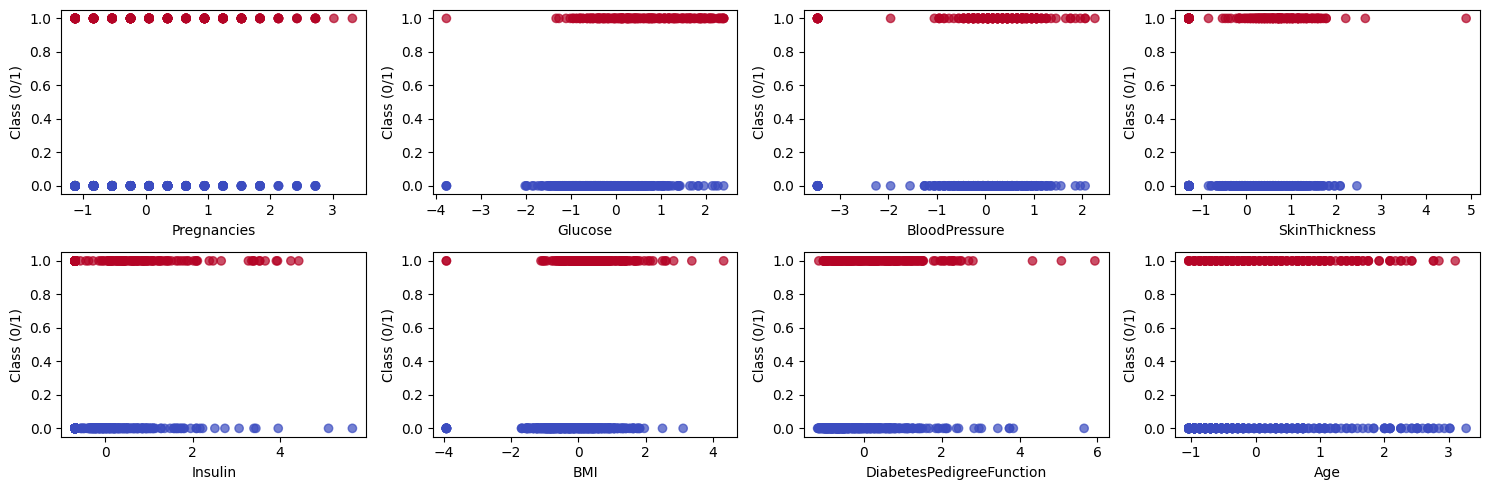


=== SVM from Scratch ===
Validation Accuracy (Scratch): 0.7532


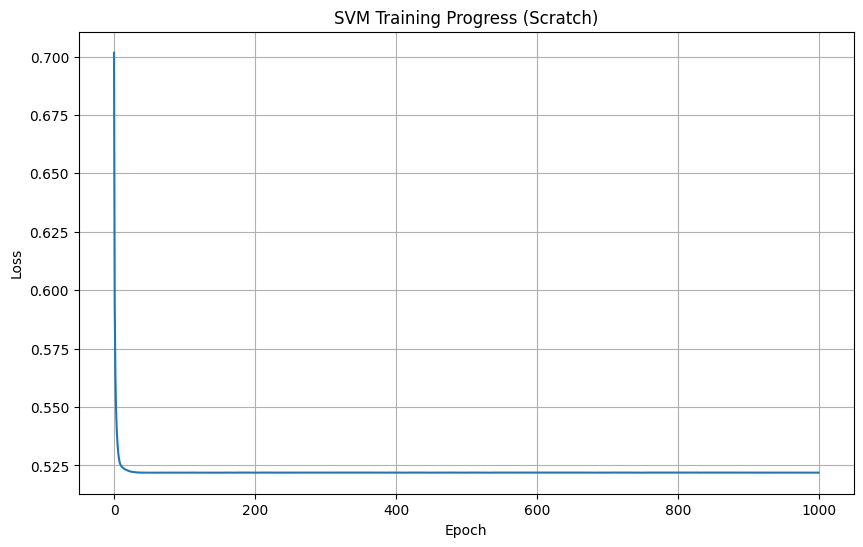


=== Sklearn SVM ===
Validation Accuracy (Sklearn): 0.7338


In [ ]:
# ===== SVM CLASSIFICATION =====
print("\n\n===== SVM CLASSIFICATION =====")

# Define file path and feature names
svm_class_data_path = "/content/diabetes.csv"
svm_class_features = ['Pregnancies', 'Glucose','BloodPressure','SkinThickness',
                      'Insulin','BMI','DiabetesPedigreeFunction','Age']

# Load data
X_train_svm, y_train_svm, X_val_svm, y_val_svm, scaler_svm = load_svm_classification_data(svm_class_data_path)

# Visualize data
print("\n=== SVM Classification Data Visualization ===")
visualize_classification_data(X_train_svm, y_train_svm, svm_class_features)

# 1. SVM from scratch
print("\n=== SVM from Scratch ===")
svm_scratch = SVMFromScratch(learning_rate=0.001, lambda_param=0.01, n_iters=1000)
svm_scratch.fit(X_train_svm, y_train_svm)
y_pred_scratch = svm_scratch.predict(X_val_svm)
accuracy_scratch = accuracy_score(y_val_svm, np.where(y_pred_scratch <= 0, 0, 1))
print(f"Validation Accuracy (Scratch): {accuracy_scratch:.4f}")

# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(svm_scratch.training_history['epoch'], svm_scratch.training_history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SVM Training Progress (Scratch)')
plt.grid(True)
plt.show()

# 2. Sklearn SVM
print("\n=== Sklearn SVM ===")
svm_sklearn = SVC(kernel='linear', C=1.0)
svm_sklearn.fit(X_train_svm, y_train_svm)
y_pred_sklearn = svm_sklearn.predict(X_val_svm)
accuracy_sklearn = accuracy_score(y_val_svm, y_pred_sklearn)
print(f"Validation Accuracy (Sklearn): {accuracy_sklearn:.4f}")



===== SVM REGRESSION =====

=== SVM Regression Data Visualization ===


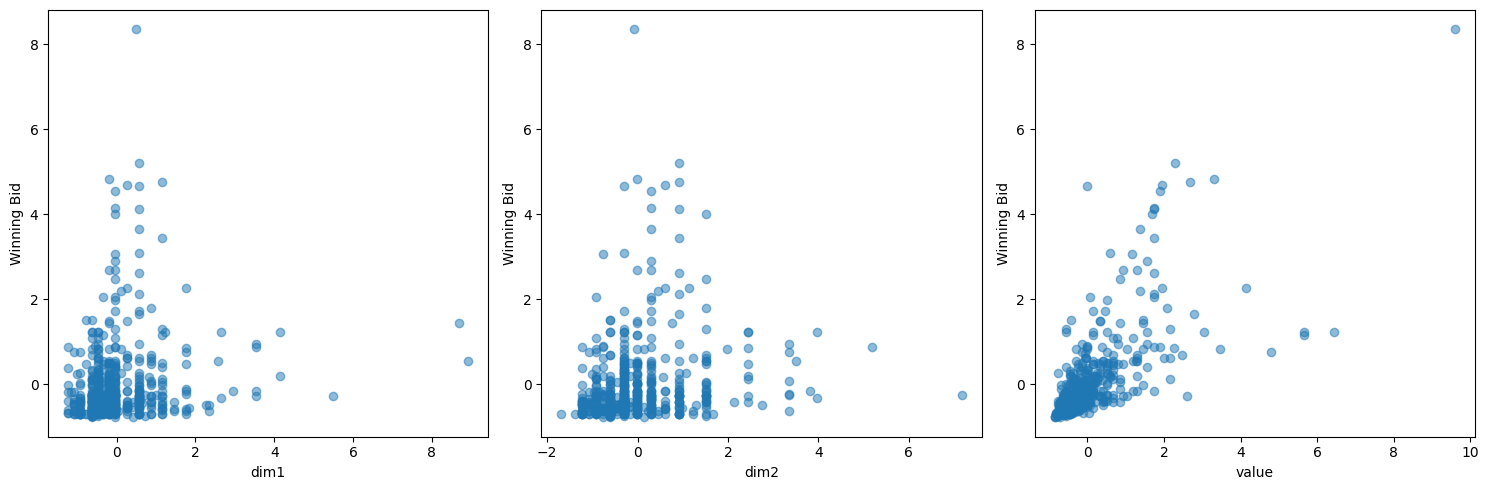


=== Sklearn SVM Regression ===
Validation MSE: 138878.6896


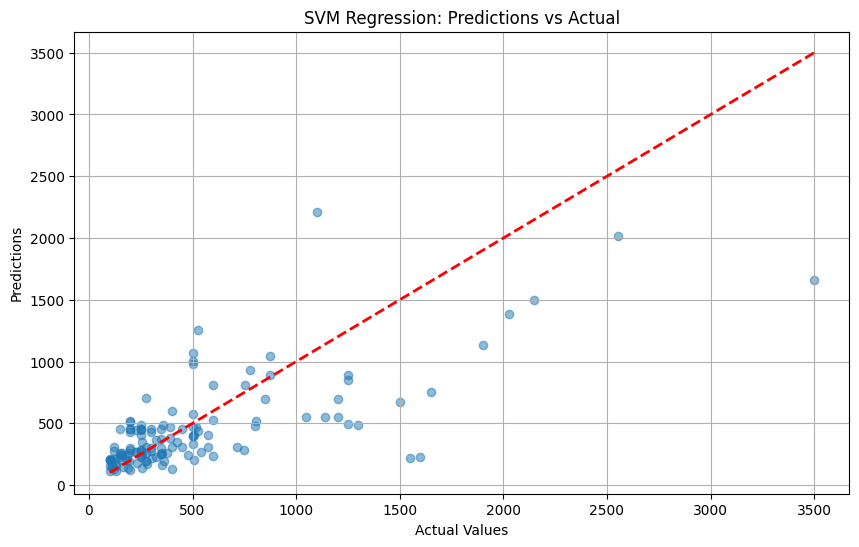

In [ ]:
# ===== SVM REGRESSION =====
print("\n\n===== SVM REGRESSION =====")

# Define file path and feature names
svm_reg_data_path = "/content/train_original.csv"
svm_reg_features = ['dim1', 'dim2', 'value']

# Load data
X_train_svmr, y_train_svmr, X_val_svmr, y_val_svmr, X_scaler_svmr, y_scaler_svmr = load_svm_regression_data(svm_reg_data_path)

# Visualize
print("\n=== SVM Regression Data Visualization ===")
visualize_regression_data(X_train_svmr, y_train_svmr, svm_reg_features)

# Sklearn SVM Regression
print("\n=== Sklearn SVM Regression ===")
svm_reg = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_reg.fit(X_train_svmr, y_train_svmr)
y_pred_svmr = svm_reg.predict(X_val_svmr)

# Inverse transform predictions and actual values
y_pred_original = y_scaler_svmr.inverse_transform(y_pred_svmr.reshape(-1, 1)).ravel()
y_val_original = y_scaler_svmr.inverse_transform(y_val_svmr.reshape(-1, 1)).ravel()
mse = mean_squared_error(y_val_original, y_pred_original)
print(f"Validation MSE: {mse:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_val_original, y_pred_original, alpha=0.5)
plt.plot([y_val_original.min(), y_val_original.max()],
         [y_val_original.min(), y_val_original.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('SVM Regression: Predictions vs Actual')
plt.grid(True)
plt.show()



===== K-MEANS CLUSTERING =====

=== K-Means from Scratch ===


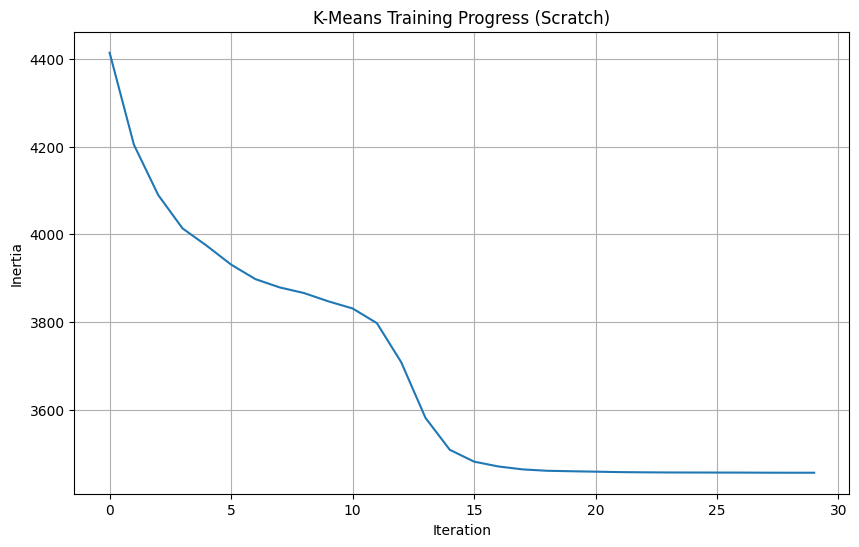

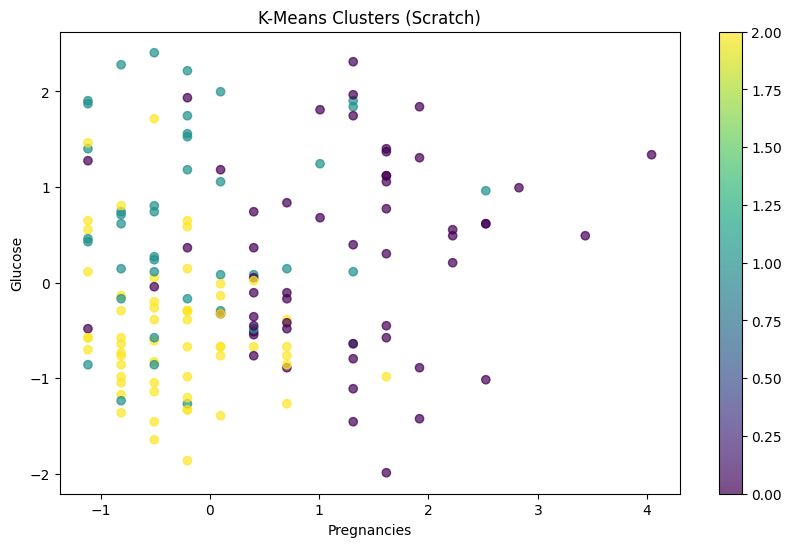


=== Sklearn K-Means ===
Silhouette Score: 0.1573


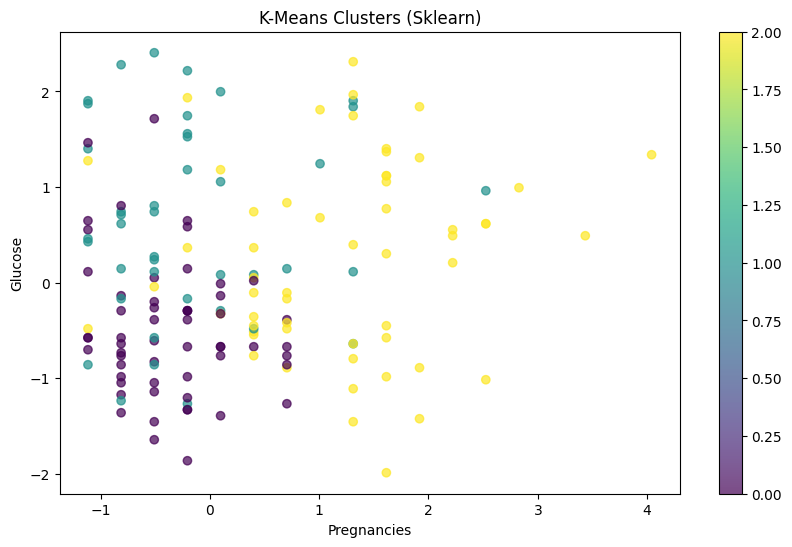

In [ ]:
# ===== K-MEANS CLUSTERING =====
print("\n\n===== K-MEANS CLUSTERING =====")

# Define file path and feature names
kmeans_data_path = "/content/diabetes.csv"
kmeans_features = ['Pregnancies', 'Glucose','BloodPressure','SkinThickness',
                   'Insulin','BMI','DiabetesPedigreeFunction','Age']

# Load data
X_train_kmeans, X_val_kmeans, scaler_kmeans = load_kmeans_data(kmeans_data_path)

# 1. K-Means from scratch
print("\n=== K-Means from Scratch ===")
kmeans_scratch = KMeansFromScratch(K=3, max_iters=100)
kmeans_scratch.fit(X_train_kmeans)
labels_scratch = kmeans_scratch.predict(X_val_kmeans)

# Plot training progress (inertia)
plt.figure(figsize=(10, 6))
plt.plot(kmeans_scratch.training_history['iteration'], kmeans_scratch.training_history['inertia'])
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.title('K-Means Training Progress (Scratch)')
plt.grid(True)
plt.show()

# Visualize clusters (using first two features)
visualize_clusters(X_val_kmeans, labels_scratch, kmeans_features[:2], "K-Means Clusters (Scratch)")

# 2. Sklearn K-Means
print("\n=== Sklearn K-Means ===")
kmeans_sklearn = KMeans(n_clusters=3, random_state=42)
kmeans_sklearn.fit(X_train_kmeans)
labels_sklearn = kmeans_sklearn.predict(X_val_kmeans)

# Evaluate clustering performance
silhouette = silhouette_score(X_val_kmeans, labels_sklearn)
print(f"Silhouette Score: {silhouette:.4f}")

# Visualize clusters (using first two features)
visualize_clusters(X_val_kmeans, labels_sklearn, kmeans_features[:2], "K-Means Clusters (Sklearn)")